# Baseline Models

In [7]:
# Import Packages
from Code.find_path_nextcloud import find_path_nextcloud
import matplotlib.pyplot as plt
import spectral as spy
import pandas as pd
import numpy as np
import os
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from numpy import unique
from sklearn.metrics import confusion_matrix
import time

* Funktionen

In [8]:
def isfloat(num):
    try:
        float(num)
        return True
    except ValueError:
        return False

In [9]:
def import_labeled_data():

    # Pfad Nextcloud bestimmen
    path_nextcloud = find_path_nextcloud()

    # Festlegung, welches Grid zusammengelegt werden soll
    windowsize_r = 200
    windowsize_c = 200

    # Bestimmung annotation_folder
    # grid_folder = path_nextcloud + "Daten_Gyrocopter/Oldenburg/Teilbilder/grid_" + str(windowsize_r) + "_" + str(windowsize_c)
    # labeled_folder = grid_folder + '/labeled/'
    labeled_folder = 'C:/Users/fgrassxx/Desktop/Oldenburg/Oldenburg_grid_200_200/labeled/'
    # Liste aller Dateien in annotation_folder erstellen
    files = os.listdir(labeled_folder)

    # Aus Liste files .hdr Dateien löschen
    for file in files:
        if not file.endswith('.dat'):
            files.remove(file)

    # Spaltennamen des DataFrames bilden
    path_dat = labeled_folder + os.path.splitext(files[0])[0] + '.dat'
    path_hdr = labeled_folder + os.path.splitext(files[0])[0] + '.hdr'

    # load image
    img = spy.envi.open(file=path_hdr, image=path_dat)

    # convert only wavelength into dataframe and round numbers
    value_bands = ['hsi_band_' + str(int(float(x))) + '_nm' for x in img.metadata['wavelength'] if isfloat(x)]
    value_bands.extend(['thermal', 'dom'])

    label_bands = ['label']

    bands = []
    bands.extend(value_bands)
    bands.extend(label_bands)
    bands.append('picture_name')

    df_annotations = pd.DataFrame(columns=bands)

    # labeled Bilder erstellen
    for filename in files[:]:
        path_dat = labeled_folder + os.path.splitext(filename)[0] + '.dat'
        path_hdr = labeled_folder + os.path.splitext(filename)[0] + '.hdr'
        img = spy.envi.open(file=path_hdr, image=path_dat)

        arr = img.load()

        df = pd.DataFrame(arr.reshape(((arr.shape[0]*arr.shape[1]), arr.shape[2])), columns=bands[:-1])
        df['picture_name'] = os.path.splitext(filename)[0]

        df_annotations = pd.concat([df_annotations, df], ignore_index=True)

        df_annotations['label'] = df_annotations['label'].astype(int)


    return df_annotations

Daten als DataFrame einlesen

In [10]:
df_annotations = import_labeled_data()
df_annotations['label'] = df_annotations['label'].replace({0:'None',1:'Wiese', 2:'Straße',3: 'Auto', 4:'See', 5:'Schienen', 6:'Haus', 7:'Wald'})

In [11]:
df_annotations.iloc[:3,:5]

,hsi_band_430_nm,hsi_band_434_nm,hsi_band_439_nm,hsi_band_443_nm,hsi_band_448_nm
0,1314.0,1369.0,1487.0,1572.0,1614.0
1,1301.0,1389.0,1501.0,1557.0,1679.0
2,1362.0,1494.0,1543.0,1546.0,1649.0


In [12]:
df_annotations.iloc[:3,-5:]

,hsi_band_925_nm,thermal,dom,label,picture_name
0,2554.0,0.0,0.0,None,Teilbild_Oldenburg_00000000_00000000_0_0_
1,2551.0,0.0,0.0,None,Teilbild_Oldenburg_00000000_00000000_0_0_
2,2579.0,0.0,0.0,None,Teilbild_Oldenburg_00000000_00000000_0_0_


Aufteilung in Trainings- und Testdaten

In [13]:
X = df_annotations.drop(columns=['label', 'picture_name'])
Y = df_annotations['label']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3)

## KNN

Accuracy: 76.93549905838042
              precision    recall  f1-score   support

        Auto       0.68      0.24      0.36      3342
        Haus       0.81      0.80      0.80     40392
        None       0.75      0.75      0.75     65564
    Schienen       0.87      0.53      0.65      1295
         See       0.99      0.98      0.99     23664
        Wald       0.67      0.81      0.73     35471
       Wiese       0.72      0.68      0.70     42672

    accuracy                           0.77    212400
   macro avg       0.79      0.68      0.71    212400
weighted avg       0.77      0.77      0.77    212400



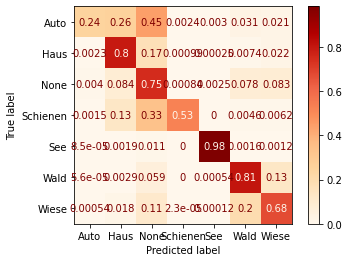

In [14]:
# save start time
start = time.process_time()

# Train
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train, y_train)

# Test
knn_pred = knn.predict(X_test)

# save end time
end = time.process_time()

# calculate runtime
time = end - start


# Result
print(f'Laufzeit in Sekunden{time.__round__(1)}')
print(f"Accuracy: {accuracy_score(y_test, knn_pred) * 100}")
print(classification_report(y_test, knn_pred))
cm = confusion_matrix(y_test, knn_pred, labels=list(unique(knn_pred)), normalize='true')
disp = ConfusionMatrixDisplay(cm, display_labels=list(unique(knn_pred)))
disp.plot(cmap="OrRd")

### KNN mit Grid-Search

In [16]:
from sklearn.model_selection import GridSearchCV
import time

In [ ]:
parameters = {'n_neighbors':[1,5,10,20,30], 'weights':['uniform', 'distance'], 'p':[2]}

classifier = GridSearchCV(estimator = KNeighborsClassifier(n_jobs=-1),
                          param_grid = parameters,
                          scoring = "f1_macro",
                          n_jobs = -1,
                          refit = True,
                          cv = 2, # Crossvalidation k-folds
                          verbose = 3,
                          pre_dispatch ='2*n_jobs',
                          error_score = np.nan,
                          return_train_score = False)


In [ ]:
start = time.process_time()
classifier.fit(X=X, y=Y)
end = time.process_time()

time = end - start